In [1]:
!pip install torch torchvision

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 57.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 31.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 32.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 62.3 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlin

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader

In [3]:
# 1. Hyperparameters
batch_size = 128
num_epochs = 5
learning_rate = 1e-3
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [4]:
# 2. Data loaders
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),   # random crop first pads with 4 and then randomly picks 32x32 section everytime image is loaded
    transforms.RandomHorizontalFlip(),      # this helps in different views of same image and makes model robust
    transforms.ToTensor(),
    transforms.Normalize((0.4914,0.4822,0.4465),
                         (0.2470,0.2435,0.2616)),
])
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914,0.4822,0.4465),
                         (0.2470,0.2435,0.2616)),
])

train_ds = datasets.CIFAR10(root='./data', train=True,
                            download=True, transform=transform_train)
test_ds  = datasets.CIFAR10(root='./data', train=False,
                            download=True, transform=transform_test)

train_loader = DataLoader(train_ds, batch_size=batch_size,
                          shuffle=True, num_workers=2)
test_loader  = DataLoader(test_ds,  batch_size=batch_size,
                          shuffle=False, num_workers=2)

100%|██████████| 170M/170M [00:01<00:00, 91.9MB/s]


In [5]:
# 3. Model
model = models.resnet18(pretrained=True)
# Replace final FC layer (512→1000) with (512→10)
model.fc = nn.Linear(model.fc.in_features, 10)
model = model.to(device)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 130MB/s]


In [6]:
# 4. Loss & optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [7]:
# 5. Training loop
for epoch in range(1, num_epochs+1):
    model.train()
    running_loss = 0.0
    for imgs, labels in train_loader:
        imgs, labels = imgs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * imgs.size(0)
    epoch_loss = running_loss / len(train_loader.dataset)
    print(f"Epoch {epoch}/{num_epochs} — Loss: {epoch_loss:.4f}")

    # 6. Validation
    model.eval()
    correct = 0
    with torch.no_grad():
        for imgs, labels in test_loader:
            imgs, labels = imgs.to(device), labels.to(device)
            preds = model(imgs).argmax(dim=1)
            correct += (preds == labels).sum().item()
    acc = correct / len(test_loader.dataset)
    print(f" → Test Accuracy: {acc*100:.2f}%\n")

Epoch 1/5 — Loss: 1.0522
 → Test Accuracy: 73.70%

Epoch 2/5 — Loss: 0.7500
 → Test Accuracy: 76.66%

Epoch 3/5 — Loss: 0.6548
 → Test Accuracy: 79.13%

Epoch 4/5 — Loss: 0.5886
 → Test Accuracy: 79.66%

Epoch 5/5 — Loss: 0.5602
 → Test Accuracy: 80.27%



In [11]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

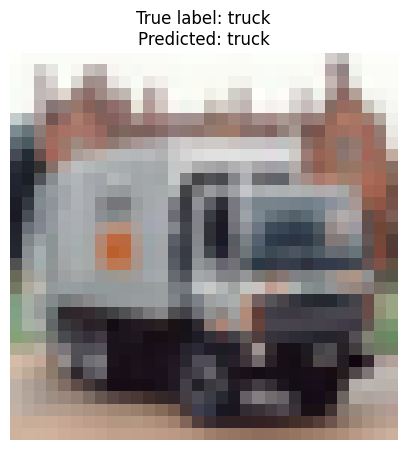

In [16]:
# Class labels
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

# Function to unnormalize image tensor
def unnormalize(img_tensor):
    mean = np.array([0.4914, 0.4822, 0.4465])
    std = np.array([0.2470, 0.2435, 0.2616])
    img = img_tensor.permute(1, 2, 0).cpu().numpy()  # CxHxW → HxWxC
    img = img * std + mean  # Unnormalize
    img = np.clip(img * 255, 0, 255).astype(np.uint8)
    return img

model.eval()
image_tensor, label = test_ds[11]  # Pick any index here
input_tensor = image_tensor.unsqueeze(0).to(device)   # this step is required for making batch of size 1 [1,C,H,W] which is expected by model

# Predict
with torch.no_grad():
    output = model(input_tensor)
    pred_label = output.argmax(dim=1).item()

# Unnormalizing image
image_np = unnormalize(image_tensor)

# Display using matplotlib
plt.figure(figsize=(5, 6))
plt.imshow(image_np)
plt.axis('off')

# Print labels below the image
true_text = f"True label: {class_names[label]}"
pred_text = f"Predicted: {class_names[pred_label]}"
plt.title(true_text + "\n" + pred_text, fontsize=12)
plt.show()

### Some important Information
While matplotlib, openCV, tensorflow requires images to be in format HxWxC i.e height, width, channels (RGB), buth pytorch rquires format CxHxW to perform convolutions by design.

Always pass normalised dataset to dataloaders where normalisation means zero centering and dividing by std dev. For visualisation tasks unnormalise back to original images.

nn.Loss_fn always expect first argument to be vector of scores and second argument to be true label (single integer). Internally it will find predicted class using softmax and calculate loss.